In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [3]:
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
#filename = '/content/drive/My Drive/luna_lab/car_plate_sample/'
filename = './augmented_data/'

In [43]:
trans = torchvision.transforms.Compose([
                                        transforms.Resize((224,224)), #image net의 input 형태
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5),(0.5))
                                        ])

In [44]:
dataset = torchvision.datasets.ImageFolder(root = filename,
                                        transform = trans)

In [45]:
classes = dataset.classes

In [46]:
print(len(classes))

82


In [47]:
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [48]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [49]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                                sampler=valid_sampler)

In [13]:
model_name = 'efficientnet-b0'  # b5
image_size = EfficientNet.get_image_size(model_name)
model = EfficientNet.from_pretrained(model_name, num_classes=82)

Loaded pretrained weights for efficientnet-b0


In [19]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [51]:
log_interval = 200

In [56]:
for epoch in tqdm(range(3)):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % log_interval == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 4.458228
Train Epoch: 0 Loss: 3.776228
Train Epoch: 0 Loss: 3.496870


RuntimeError: python_error

In [58]:
PATH = './car_efficientNet.pth'
torch.save(model.state_dict(), PATH)

In [59]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

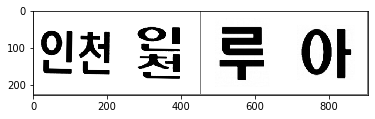

GroundTruth:      d    dv    fn    dk


In [60]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [62]:
net = model
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [63]:
outputs = net(images)

In [64]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))

Predicted:      m


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (100 * correct / total))



  0%|                                                                                         | 0/8615 [00:00<?, ?it/s]

  0%|                                                                               | 1/8615 [00:00<1:07:37,  2.12it/s]

  0%|                                                                               | 2/8615 [00:00<1:07:22,  2.13it/s]

  0%|                                                                               | 3/8615 [00:01<1:10:06,  2.05it/s]

  0%|                                                                               | 4/8615 [00:01<1:10:07,  2.05it/s]

  0%|                                                                               | 5/8615 [00:02<1:08:59,  2.08it/s]

  0%|                                                                               | 6/8615 [00:02<1:09:33,  2.06it/s]

  0%|                                                                               | 7/8615 [00:03<1:10:19,  2.04it/s]

  0%|                         

  1%|▌                                                                             | 64/8615 [00:37<1:36:03,  1.48it/s]

  1%|▌                                                                             | 65/8615 [00:38<1:34:50,  1.50it/s]

  1%|▌                                                                             | 66/8615 [00:38<1:30:56,  1.57it/s]

  1%|▌                                                                             | 67/8615 [00:39<1:29:09,  1.60it/s]

  1%|▌                                                                             | 68/8615 [00:40<1:36:27,  1.48it/s]

  1%|▌                                                                             | 69/8615 [00:40<1:35:27,  1.49it/s]

  1%|▋                                                                             | 70/8615 [00:41<1:35:50,  1.49it/s]

  1%|▋                                                                             | 71/8615 [00:42<1:41:23,  1.40it/s]

  1%|▋                          

  1%|█▏                                                                           | 128/8615 [01:26<2:28:20,  1.05s/it]

  1%|█▏                                                                           | 129/8615 [01:27<2:14:24,  1.05it/s]

  2%|█▏                                                                           | 130/8615 [01:27<2:08:45,  1.10it/s]

  2%|█▏                                                                           | 131/8615 [01:28<2:02:01,  1.16it/s]

  2%|█▏                                                                           | 132/8615 [01:29<2:07:21,  1.11it/s]

  2%|█▏                                                                           | 133/8615 [01:30<2:10:52,  1.08it/s]

  2%|█▏                                                                           | 134/8615 [01:31<2:15:52,  1.04it/s]

  2%|█▏                                                                           | 135/8615 [01:32<2:02:45,  1.15it/s]

  2%|█▏                         

  2%|█▋                                                                           | 192/8615 [02:10<1:25:28,  1.64it/s]

  2%|█▋                                                                           | 193/8615 [02:11<1:26:45,  1.62it/s]

  2%|█▋                                                                           | 194/8615 [02:12<1:28:00,  1.59it/s]

  2%|█▋                                                                           | 195/8615 [02:12<1:28:56,  1.58it/s]

  2%|█▊                                                                           | 196/8615 [02:13<1:29:22,  1.57it/s]

  2%|█▊                                                                           | 197/8615 [02:13<1:28:13,  1.59it/s]

  2%|█▊                                                                           | 198/8615 [02:14<1:29:20,  1.57it/s]

  2%|█▊                                                                           | 199/8615 [02:15<1:30:48,  1.54it/s]

  2%|█▊                         

  3%|██▎                                                                          | 256/8615 [02:54<1:38:15,  1.42it/s]

  3%|██▎                                                                          | 257/8615 [02:55<1:35:26,  1.46it/s]

  3%|██▎                                                                          | 258/8615 [02:56<1:37:59,  1.42it/s]

  3%|██▎                                                                          | 259/8615 [02:56<1:37:50,  1.42it/s]

  3%|██▎                                                                          | 260/8615 [02:57<1:34:48,  1.47it/s]

  3%|██▎                                                                          | 261/8615 [02:58<1:32:23,  1.51it/s]

  3%|██▎                                                                          | 262/8615 [02:58<1:31:46,  1.52it/s]

  3%|██▎                                                                          | 263/8615 [02:59<1:33:05,  1.50it/s]

  3%|██▎                        

  4%|██▊                                                                          | 320/8615 [03:41<1:35:22,  1.45it/s]

  4%|██▊                                                                          | 321/8615 [03:42<1:40:17,  1.38it/s]

  4%|██▉                                                                          | 322/8615 [03:43<1:39:04,  1.40it/s]

  4%|██▉                                                                          | 323/8615 [03:43<1:35:51,  1.44it/s]

  4%|██▉                                                                          | 324/8615 [03:44<1:33:39,  1.48it/s]

  4%|██▉                                                                          | 325/8615 [03:45<1:35:50,  1.44it/s]

  4%|██▉                                                                          | 326/8615 [03:46<1:48:20,  1.28it/s]

  4%|██▉                                                                          | 327/8615 [03:46<1:52:39,  1.23it/s]

  4%|██▉                        

  4%|███▍                                                                         | 384/8615 [04:27<1:48:06,  1.27it/s]

  4%|███▍                                                                         | 385/8615 [04:28<1:42:16,  1.34it/s]

  4%|███▍                                                                         | 386/8615 [04:29<1:44:46,  1.31it/s]

  4%|███▍                                                                         | 387/8615 [04:30<1:40:09,  1.37it/s]

  5%|███▍                                                                         | 388/8615 [04:30<1:38:33,  1.39it/s]

  5%|███▍                                                                         | 389/8615 [04:31<1:38:41,  1.39it/s]

  5%|███▍                                                                         | 390/8615 [04:32<1:39:22,  1.38it/s]

  5%|███▍                                                                         | 391/8615 [04:32<1:35:49,  1.43it/s]

  5%|███▌                       

  5%|████                                                                         | 448/8615 [05:14<1:48:09,  1.26it/s]

  5%|████                                                                         | 449/8615 [05:14<1:49:58,  1.24it/s]

  5%|████                                                                         | 450/8615 [05:15<1:46:59,  1.27it/s]

  5%|████                                                                         | 451/8615 [05:16<1:46:17,  1.28it/s]

  5%|████                                                                         | 452/8615 [05:17<1:42:17,  1.33it/s]

  5%|████                                                                         | 453/8615 [05:17<1:38:26,  1.38it/s]

  5%|████                                                                         | 454/8615 [05:18<1:37:39,  1.39it/s]

  5%|████                                                                         | 455/8615 [05:19<1:43:04,  1.32it/s]

  5%|████                       

  6%|████▌                                                                        | 512/8615 [06:00<1:34:03,  1.44it/s]

  6%|████▌                                                                        | 513/8615 [06:00<1:33:03,  1.45it/s]

  6%|████▌                                                                        | 514/8615 [06:01<1:32:40,  1.46it/s]

  6%|████▌                                                                        | 515/8615 [06:02<1:32:37,  1.46it/s]

  6%|████▌                                                                        | 516/8615 [06:02<1:30:43,  1.49it/s]

  6%|████▌                                                                        | 517/8615 [06:03<1:31:02,  1.48it/s]

  6%|████▋                                                                        | 518/8615 [06:04<1:33:59,  1.44it/s]

  6%|████▋                                                                        | 519/8615 [06:05<1:41:13,  1.33it/s]

  6%|████▋                      

  7%|█████▏                                                                       | 576/8615 [06:47<1:33:36,  1.43it/s]

  7%|█████▏                                                                       | 577/8615 [06:48<1:32:24,  1.45it/s]

  7%|█████▏                                                                       | 578/8615 [06:49<1:31:23,  1.47it/s]

  7%|█████▏                                                                       | 579/8615 [06:49<1:31:58,  1.46it/s]

  7%|█████▏                                                                       | 580/8615 [06:50<1:42:10,  1.31it/s]

  7%|█████▏                                                                       | 581/8615 [06:51<1:45:25,  1.27it/s]

  7%|█████▏                                                                       | 582/8615 [06:52<1:41:33,  1.32it/s]

  7%|█████▏                                                                       | 583/8615 [06:53<1:44:36,  1.28it/s]

  7%|█████▏                     

  7%|█████▋                                                                       | 640/8615 [07:32<1:29:27,  1.49it/s]

  7%|█████▋                                                                       | 641/8615 [07:32<1:27:18,  1.52it/s]

  7%|█████▋                                                                       | 642/8615 [07:33<1:25:16,  1.56it/s]

  7%|█████▋                                                                       | 643/8615 [07:34<1:26:55,  1.53it/s]

  7%|█████▊                                                                       | 644/8615 [07:34<1:28:09,  1.51it/s]

  7%|█████▊                                                                       | 645/8615 [07:35<1:28:28,  1.50it/s]

  7%|█████▊                                                                       | 646/8615 [07:36<1:28:16,  1.50it/s]

  8%|█████▊                                                                       | 647/8615 [07:36<1:28:35,  1.50it/s]

  8%|█████▊                     

  8%|██████▎                                                                      | 704/8615 [08:13<1:22:16,  1.60it/s]

  8%|██████▎                                                                      | 705/8615 [08:14<1:22:57,  1.59it/s]

  8%|██████▎                                                                      | 706/8615 [08:14<1:22:32,  1.60it/s]

  8%|██████▎                                                                      | 707/8615 [08:15<1:24:20,  1.56it/s]

  8%|██████▎                                                                      | 708/8615 [08:16<1:23:01,  1.59it/s]

  8%|██████▎                                                                      | 709/8615 [08:16<1:21:38,  1.61it/s]

  8%|██████▎                                                                      | 710/8615 [08:17<1:20:43,  1.63it/s]

  8%|██████▎                                                                      | 711/8615 [08:17<1:19:59,  1.65it/s]

  8%|██████▎                    

  9%|██████▊                                                                      | 768/8615 [08:54<1:25:12,  1.53it/s]

  9%|██████▊                                                                      | 769/8615 [08:55<1:25:22,  1.53it/s]

  9%|██████▉                                                                      | 770/8615 [08:55<1:27:16,  1.50it/s]

  9%|██████▉                                                                      | 771/8615 [08:56<1:26:45,  1.51it/s]

  9%|██████▉                                                                      | 772/8615 [08:57<1:27:12,  1.50it/s]

  9%|██████▉                                                                      | 773/8615 [08:58<1:29:16,  1.46it/s]

  9%|██████▉                                                                      | 774/8615 [08:58<1:31:14,  1.43it/s]

  9%|██████▉                                                                      | 775/8615 [08:59<1:30:34,  1.44it/s]

  9%|██████▉                    

 10%|███████▍                                                                     | 832/8615 [09:37<1:55:25,  1.12it/s]

 10%|███████▍                                                                     | 833/8615 [09:38<1:46:24,  1.22it/s]

 10%|███████▍                                                                     | 834/8615 [09:38<1:39:22,  1.30it/s]

 10%|███████▍                                                                     | 835/8615 [09:39<1:34:25,  1.37it/s]

 10%|███████▍                                                                     | 836/8615 [09:39<1:29:17,  1.45it/s]

 10%|███████▍                                                                     | 837/8615 [09:40<1:33:09,  1.39it/s]

 10%|███████▍                                                                     | 838/8615 [09:41<1:39:17,  1.31it/s]

 10%|███████▍                                                                     | 839/8615 [09:42<1:42:26,  1.27it/s]

 10%|███████▌                   

 10%|████████                                                                     | 896/8615 [10:20<1:24:40,  1.52it/s]

 10%|████████                                                                     | 897/8615 [10:21<1:24:42,  1.52it/s]

 10%|████████                                                                     | 898/8615 [10:21<1:24:45,  1.52it/s]

 10%|████████                                                                     | 899/8615 [10:22<1:24:17,  1.53it/s]

 10%|████████                                                                     | 900/8615 [10:23<1:24:10,  1.53it/s]

 10%|████████                                                                     | 901/8615 [10:23<1:22:22,  1.56it/s]

 10%|████████                                                                     | 902/8615 [10:24<1:22:29,  1.56it/s]

 10%|████████                                                                     | 903/8615 [10:25<1:22:53,  1.55it/s]

 10%|████████                   

 11%|████████▌                                                                    | 960/8615 [11:02<1:29:30,  1.43it/s]

 11%|████████▌                                                                    | 961/8615 [11:03<1:28:10,  1.45it/s]

 11%|████████▌                                                                    | 962/8615 [11:04<1:25:52,  1.49it/s]

 11%|████████▌                                                                    | 963/8615 [11:04<1:24:03,  1.52it/s]

 11%|████████▌                                                                    | 964/8615 [11:05<1:23:49,  1.52it/s]

 11%|████████▋                                                                    | 965/8615 [11:06<1:24:29,  1.51it/s]

 11%|████████▋                                                                    | 966/8615 [11:06<1:23:39,  1.52it/s]

 11%|████████▋                                                                    | 967/8615 [11:07<1:25:04,  1.50it/s]

 11%|████████▋                  

 12%|█████████                                                                   | 1024/8615 [11:44<1:23:29,  1.52it/s]

 12%|█████████                                                                   | 1025/8615 [11:45<1:26:01,  1.47it/s]

 12%|█████████                                                                   | 1026/8615 [11:45<1:25:08,  1.49it/s]

 12%|█████████                                                                   | 1027/8615 [11:46<1:24:56,  1.49it/s]

 12%|█████████                                                                   | 1028/8615 [11:46<1:24:44,  1.49it/s]

 12%|█████████                                                                   | 1029/8615 [11:47<1:22:29,  1.53it/s]

 12%|█████████                                                                   | 1030/8615 [11:48<1:23:26,  1.51it/s]

 12%|█████████                                                                   | 1031/8615 [11:48<1:22:31,  1.53it/s]

 12%|█████████                  

 13%|█████████▌                                                                  | 1088/8615 [12:25<1:24:36,  1.48it/s]

 13%|█████████▌                                                                  | 1089/8615 [12:26<1:21:26,  1.54it/s]

 13%|█████████▌                                                                  | 1090/8615 [12:26<1:20:11,  1.56it/s]

 13%|█████████▌                                                                  | 1091/8615 [12:27<1:19:48,  1.57it/s]

 13%|█████████▋                                                                  | 1092/8615 [12:28<1:19:03,  1.59it/s]

 13%|█████████▋                                                                  | 1093/8615 [12:28<1:19:55,  1.57it/s]

 13%|█████████▋                                                                  | 1094/8615 [12:29<1:19:40,  1.57it/s]

 13%|█████████▋                                                                  | 1095/8615 [12:30<1:21:02,  1.55it/s]

 13%|█████████▋                 

 13%|██████████▏                                                                 | 1152/8615 [13:07<1:19:55,  1.56it/s]

 13%|██████████▏                                                                 | 1153/8615 [13:08<1:18:59,  1.57it/s]

 13%|██████████▏                                                                 | 1154/8615 [13:09<1:18:47,  1.58it/s]

 13%|██████████▏                                                                 | 1155/8615 [13:09<1:20:48,  1.54it/s]

 13%|██████████▏                                                                 | 1156/8615 [13:10<1:20:40,  1.54it/s]

 13%|██████████▏                                                                 | 1157/8615 [13:11<1:21:26,  1.53it/s]

 13%|██████████▏                                                                 | 1158/8615 [13:11<1:19:17,  1.57it/s]

 13%|██████████▏                                                                 | 1159/8615 [13:12<1:21:59,  1.52it/s]

 13%|██████████▏                

 14%|██████████▋                                                                 | 1216/8615 [13:54<2:07:56,  1.04s/it]

 14%|██████████▋                                                                 | 1217/8615 [13:55<2:06:26,  1.03s/it]

 14%|██████████▋                                                                 | 1218/8615 [13:56<1:59:41,  1.03it/s]

 14%|██████████▊                                                                 | 1219/8615 [13:57<2:00:27,  1.02it/s]

 14%|██████████▊                                                                 | 1220/8615 [13:58<1:58:19,  1.04it/s]

 14%|██████████▊                                                                 | 1221/8615 [13:59<1:59:11,  1.03it/s]

 14%|██████████▊                                                                 | 1222/8615 [14:00<2:07:50,  1.04s/it]

 14%|██████████▊                                                                 | 1223/8615 [14:01<1:58:19,  1.04it/s]

 14%|██████████▊                

 15%|███████████▎                                                                | 1280/8615 [14:41<1:20:31,  1.52it/s]

 15%|███████████▎                                                                | 1281/8615 [14:42<1:21:08,  1.51it/s]

 15%|███████████▎                                                                | 1282/8615 [14:42<1:20:40,  1.51it/s]

 15%|███████████▎                                                                | 1283/8615 [14:43<1:19:00,  1.55it/s]

 15%|███████████▎                                                                | 1284/8615 [14:44<1:18:35,  1.55it/s]

 15%|███████████▎                                                                | 1285/8615 [14:44<1:16:25,  1.60it/s]

 15%|███████████▎                                                                | 1286/8615 [14:45<1:19:40,  1.53it/s]

 15%|███████████▎                                                                | 1287/8615 [14:46<1:22:29,  1.48it/s]

 15%|███████████▎               